In [4]:
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch

In [2]:
import os

print(os.listdir("/kaggle/input"))


['face-morph-dsp']


In [5]:
class PairDataset(Dataset):
    def __init__(self, csv_file, transform=None, cache=False):
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        self.cache = cache
        self.cache_dict = {}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):

        # If cached, load from RAM
        if self.cache and idx in self.cache_dict:
            img1, img2 = self.cache_dict[idx]
        else:
            row = self.df.iloc[idx]
            img1_path = row["image1"]
            img2_path = row["image2"]

            with Image.open(img1_path) as im1:
                img1 = im1.convert("RGB").copy()
            with Image.open(img2_path) as im2:
                img2 = im2.convert("RGB").copy()

            if self.cache:
                self.cache_dict[idx] = (img1, img2)

        label = torch.tensor(self.df.iloc[idx]["label"], dtype=torch.long)

        # Apply transforms
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2, label


In [6]:
from torchvision import transforms
pair_transform = transforms.Compose([
    transforms.Resize((256, 256)),      # fixed size = no more mismatch
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1)),
    transforms.RandomPerspective(distortion_scale=0.3, p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

from torchvision import transforms
test_transform = transforms.Compose([
    transforms.Resize((256, 256)),    # must match training
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [7]:
# FEI Train
dmad_train_loader = DataLoader(
    PairDataset("/kaggle/input/face-morph-dsp/dataset_info/FEI_train.csv", pair_transform, cache=True),
    batch_size=8,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

# FEI Val
dmad_val_loader = DataLoader(
    PairDataset("/kaggle/input/face-morph-dsp/dataset_info/FEI_val.csv", test_transform, cache=True),
    batch_size=8,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

# FRLL Fine-tune Loader
frll_finetune_loader = DataLoader(
    PairDataset("/kaggle/input/face-morph-dsp/dataset_info/FRLL_finetune.csv", pair_transform, cache=True),
    batch_size=8,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class SharedEffB3Encoder(nn.Module):
    def __init__(self, weights_path=None, freeze_backbone=False):
        super().__init__()

        # Same architecture as S-MAD
        base_model = efficientnet_b3(weights=EfficientNet_B3_Weights.IMAGENET1K_V1)
        num_features = base_model.classifier[1].in_features
        base_model.classifier[1] = nn.Linear(num_features, 2)

        if weights_path is not None:
            state = torch.load(weights_path, map_location=device)
            base_model.load_state_dict(state)
            print("✅ Loaded S-MAD weights into EfficientNet-B3 encoder")

        # Use only feature extractor + pooling
        self.features = base_model.features
        self.pool = nn.AdaptiveAvgPool2d(1)  # global average pool

        if freeze_backbone:
            for p in self.parameters():
                p.requires_grad = False

        # For EfficientNet-B3, this should be 1536
        self.out_dim = num_features  

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)   # (B, 1536)
        return x


In [10]:
import math

class ArcMarginProduct(nn.Module):
    def __init__(self, in_features, out_features=2, s=30.0, m=0.5, easy_margin=False):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m

        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        self.easy_margin = easy_margin
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, input, label=None):
        # input: (B, in_features)
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))  # (B, out_features)

        if label is None:
            # Inference mode (no margin)
            return cosine * self.s

        sine = torch.sqrt(1.0 - torch.clamp(cosine ** 2, 0, 1))
        phi = cosine * self.cos_m - sine * self.sin_m

        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)

        one_hot = F.one_hot(label, num_classes=self.out_features).float().to(input.device)

        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s
        return output


In [11]:
class DMAD_SiameseArcFace(nn.Module):
    def __init__(self, shared_encoder, embed_dim=512, margin=0.5, scale=30.0):
        super().__init__()
        self.encoder = shared_encoder



        # Project 1536 → 512-d embedding
        self.fc_embed = nn.Linear(self.encoder.out_dim, embed_dim)

        # ArcFace head on pair embedding
        self.arcface = ArcMarginProduct(in_features=embed_dim, 
                                        out_features=2, 
                                        m=margin, 
                                        s=scale)

    def forward(self, img1, img2, labels=None):
        # Shared encoder
        f1 = self.encoder(img1)   # (B, 1536)
        f2 = self.encoder(img2)   # (B, 1536)

        e1 = F.normalize(self.fc_embed(f1))  # (B, 512)
        e2 = F.normalize(self.fc_embed(f2))  # (B, 512)

        # Cosine similarity between embeddings
        cosine_sim = F.cosine_similarity(e1, e2)  # (B,)

        # Pair embedding for ArcFace (absolute difference)
        pair_embed = torch.abs(e1 - e2)  # (B, 512)

        if labels is not None:
            logits = self.arcface(pair_embed, labels.long())
        else:
            logits = self.arcface(pair_embed, None)

        return logits, cosine_sim


In [12]:
# 🔹 Create encoder from your S-MAD checkpoint
encoder = SharedEffB3Encoder(weights_path="/kaggle/input/face-morph-dsp/efficientnet_b3_morphing.pth", freeze_backbone=False).to(device)
dmad_model = DMAD_SiameseArcFace(encoder, embed_dim=512, margin=0.5, scale=30.0).to(device)


Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 127MB/s] 


✅ Loaded S-MAD weights into EfficientNet-B3 encoder


In [14]:
def contrastive_loss_cosine(cosine_sim, labels, margin=0.5):
    """
    labels: 0 (same/bonafide), 1 (different/morph)
    cosine_sim: higher means more similar
    """
    # Convert labels to float
    labels = labels.float()

    # For genuine pairs (label=0) → want cosine_sim → 1
    pos_loss = (1 - labels) * (1.0 - cosine_sim) ** 2

    # For morph pairs (label=1) → want cosine_sim < margin
    neg_loss = labels * torch.clamp(cosine_sim - margin, min=0) ** 2

    loss = (pos_loss + neg_loss).mean()
    return loss


In [18]:
import os
import torch.optim as optim
import copy
import torch.nn as nn

criterion_ce = nn.CrossEntropyLoss()
lambda_contrastive = 0.6

CHECKPOINT_PATH = "/kaggle/working/dmad_checkpoint_0.6.pth"

# ================================================
# 🔥 TRAIN FUNCTION WITH FREEZE + LOWER LR ADDED
# ================================================
def train_dmad(
        model, 
        train_loader, 
        val_loader, 
        optimizer=None,
        num_epochs=10,
        freeze_epochs=2,           # freeze encoder for first 2 epochs
        reset_checkpoint=False
    ):

    # -----------------------------
    # (1) OPTIMIZER SETUP
    # -----------------------------
    default_optimizer_used = False
    if optimizer is None:
        optimizer = optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-4)
        # lr reduced from 1e-4 → 5e-5 for stability
        default_optimizer_used = True

    best_val_acc = 0.0
    best_wts = copy.deepcopy(model.state_dict())
    start_epoch = 0

    # -----------------------------
    # (2) LOAD CHECKPOINT IF EXISTS
    # -----------------------------
    if os.path.exists(CHECKPOINT_PATH) and not reset_checkpoint and default_optimizer_used:
        print("Loading existing checkpoint...")
        checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)

        model.load_state_dict(checkpoint["model_state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        best_val_acc = checkpoint["best_val_acc"]
        start_epoch = checkpoint["epoch"]

        print(f"Resuming training from epoch {start_epoch+1}")
    else:
        print("Starting from epoch 1 (checkpoint ignored/reset).")
        start_epoch = 0

    # ============================================
    # 🔥 FREEZE ENCODER FOR FIRST freeze_epochs
    # ============================================
    for p in model.encoder.parameters():
        p.requires_grad = False
    print(f"Encoder frozen for first {freeze_epochs} epochs.")

    # ============================================
    # 🔥 TRAINING LOOP
    # ============================================
    for epoch in range(start_epoch, num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 40)

        # ---------------------------------------------------
        # 🌟 UNFREEZE ENCODER AFTER freeze_epochs
        # ---------------------------------------------------
        if epoch == freeze_epochs:
            for p in model.encoder.parameters():
                p.requires_grad = True
            print(f"Encoder UNFROZEN at epoch {epoch+1} ✔")

        for phase in ["train", "val"]:
            model.train() if phase == "train" else model.eval()
            dataloader = train_loader if phase == "train" else val_loader

            running_loss = 0.0
            running_corrects = 0
            total = 0

            for img1, img2, labels in dataloader:
                img1, img2, labels = img1.to(device), img2.to(device), labels.long().to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    logits, cosine_sim = model(img1, img2, labels)

                    loss_ce = criterion_ce(logits, labels)
                    loss_contrastive = contrastive_loss_cosine(cosine_sim, labels)
                    loss = loss_ce + lambda_contrastive * loss_contrastive

                    _, preds = torch.max(logits, 1)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * labels.size(0)
                running_corrects += torch.sum(preds == labels)
                total += labels.size(0)

            epoch_loss = running_loss / total
            epoch_acc = running_corrects.double().item() / total

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == "val" and epoch_acc > best_val_acc:
                best_val_acc = epoch_acc
                best_wts = copy.deepcopy(model.state_dict())

        # ---------------------------------------------------
        # SAVE CHECKPOINT EVERY EPOCH
        # ---------------------------------------------------
        checkpoint = {
            "epoch": epoch + 1,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "best_val_acc": best_val_acc,
        }
        torch.save(checkpoint, CHECKPOINT_PATH)
        print("Checkpoint saved ✔")

    print("\nTraining finished.")
    print(f"Best val Acc: {best_val_acc:.4f}")

    model.load_state_dict(best_wts)
    return model




In [ ]:

# ============================================
# 🔥 RUN TRAINING
# ============================================
dmad_model = train_dmad(
    model=dmad_model,
    train_loader=dmad_train_loader,
    val_loader=dmad_val_loader,
    num_epochs=10,
    freeze_epochs=2,         # freeze encoder for first 2 epochs
    optimizer=None
)


Starting from epoch 1 (checkpoint ignored/reset).
Encoder frozen for first 2 epochs.

Epoch 1/10
----------------------------------------
train Loss: 11.5592 Acc: 0.0669
val Loss: 10.2324 Acc: 0.0168
Checkpoint saved ✔

Epoch 2/10
----------------------------------------
train Loss: 9.1051 Acc: 0.1092
val Loss: 8.2928 Acc: 0.0063
Checkpoint saved ✔

Epoch 3/10
----------------------------------------
Encoder UNFROZEN at epoch 3 ✔
train Loss: 5.7139 Acc: 0.2084
val Loss: 2.3639 Acc: 0.4983
Checkpoint saved ✔

Epoch 4/10
----------------------------------------
train Loss: 2.3991 Acc: 0.6339
val Loss: 0.9720 Acc: 0.8644
Checkpoint saved ✔

Epoch 5/10
----------------------------------------
train Loss: 1.5463 Acc: 0.7843
val Loss: 0.8380 Acc: 0.8927
Checkpoint saved ✔

Epoch 6/10
----------------------------------------
train Loss: 1.1167 Acc: 0.8467
val Loss: 1.9517 Acc: 0.7066
Checkpoint saved ✔

Epoch 7/10
----------------------------------------
train Loss: 0.8141 Acc: 0.8893
val Los

In [15]:
import shutil

src = "/kaggle/input/face-morph-dsp/dmad_checkpoint_0.6.pth"
dst = "/kaggle/working/dmad_checkpoint_0.6.pth"

shutil.copy(src, dst)

print("Checkpoint duplicated to working folder ✔")


Checkpoint duplicated to working folder ✔


In [20]:
# ============================================
# FINE-TUNE THE D-MAD MODEL USING FRLL
# ============================================
print("\n============== FINE-TUNING ON FRLL ==============\n")

# =======================================================
# STAGE 1 — WARM-UP (Encoder frozen)
# =======================================================
print("🔒 Stage 1: Freezing encoder for warm-up...")

for p in dmad_model.encoder.parameters():
    p.requires_grad = False    # freeze encoder

optimizer_ft = optim.AdamW(
    filter(lambda p: p.requires_grad, dmad_model.parameters()),
    lr=5e-5,
    weight_decay=1e-5
)

FRLL_STAGE1 = "/kaggle/working/dmad_frll_stage1.pth"

dmad_model = train_dmad(
    model=dmad_model,
    train_loader=frll_finetune_loader,
    val_loader=dmad_val_loader,
    optimizer=optimizer_ft,
    num_epochs=3,
    freeze_epochs=0,         # ❗ NO freeze inside training (we freeze manually)
    reset_checkpoint=True
)

torch.save(dmad_model.state_dict(), FRLL_STAGE1)
print(f"✔ Stage 1 warm-up saved to {FRLL_STAGE1}")




============== FINE-TUNING ON FRLL ==============

🔒 Stage 1: Freezing encoder for warm-up...
Starting from epoch 1 (checkpoint ignored/reset).
Encoder frozen for first 0 epochs.

Epoch 1/3
----------------------------------------
Encoder UNFROZEN at epoch 1 ✔
train Loss: 1.3191 Acc: 0.8085
val Loss: 3.6779 Acc: 0.2915
Checkpoint saved ✔

Epoch 2/3
----------------------------------------
train Loss: 1.2446 Acc: 0.8167
val Loss: 4.3269 Acc: 0.1770
Checkpoint saved ✔

Epoch 3/3
----------------------------------------
train Loss: 1.0927 Acc: 0.8378
val Loss: 3.6949 Acc: 0.2621
Checkpoint saved ✔

Training finished.
Best val Acc: 0.2915
✔ Stage 1 warm-up saved to /kaggle/working/dmad_frll_stage1.pth


In [21]:
print("Loading the FRLL First Stage model ")

dmad_model.load_state_dict(
    torch.load("dmad_frll_stage1.pth", map_location=device)
)

print("✔ FRLL Stage 1 model loaded successfully.")


Loading the FRLL First Stage model 
✔ FRLL Stage 1 model loaded successfully.


In [22]:
# =======================================================
# STAGE 2 — FULL FINE-TUNING (Encoder unfreeze)
# =======================================================
print("\n🔓 Stage 2: Unfreezing encoder for full fine-tuning...")

for p in dmad_model.encoder.parameters():
    p.requires_grad = True   # unfreeze encoder

optimizer_ft2 = optim.AdamW(
    dmad_model.parameters(),
    lr=1e-5,           # smaller LR for stability
    weight_decay=1e-5
)

FRLL_STAGE2 = "/kaggle/working/dmad_frll_stage2.pth"

dmad_model = train_dmad(
    model=dmad_model,
    train_loader=frll_finetune_loader,
    val_loader=dmad_val_loader,
    optimizer=optimizer_ft2,
    num_epochs=3,
    freeze_epochs=0,        # ❗ FULLY UNFROZEN — no auto-freeze
    reset_checkpoint=True
)

torch.save(dmad_model.state_dict(), FRLL_STAGE2)
print(f"\n🔥 Fine-tuning complete. Saved to {FRLL_STAGE2}")


🔓 Stage 2: Unfreezing encoder for full fine-tuning...
Starting from epoch 1 (checkpoint ignored/reset).
Encoder frozen for first 0 epochs.

Epoch 1/3
----------------------------------------
Encoder UNFROZEN at epoch 1 ✔
train Loss: 1.2089 Acc: 0.8361
val Loss: 3.6140 Acc: 0.3127
Checkpoint saved ✔

Epoch 2/3
----------------------------------------
train Loss: 0.9480 Acc: 0.8707
val Loss: 3.3929 Acc: 0.3944
Checkpoint saved ✔

Epoch 3/3
----------------------------------------
train Loss: 0.8610 Acc: 0.8853
val Loss: 3.5226 Acc: 0.4161
Checkpoint saved ✔

Training finished.
Best val Acc: 0.4161

🔥 Fine-tuning complete. Saved to /kaggle/working/dmad_frll_stage2.pth


In [15]:

# FEI Test (optional)
dmad_test_loader = DataLoader(
    PairDataset("/kaggle/input/face-morph-dsp/dataset_info/FEI_test.csv", test_transform, cache=True),
    batch_size=8,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)


# FRLL Test Loader
frll_test_loader = DataLoader(
    PairDataset("/kaggle/input/face-morph-dsp/dataset_info/FRLL_test.csv", test_transform, cache=True),
    batch_size=8,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)


In [31]:
import numpy as np
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, 
    f1_score, roc_auc_score, roc_curve
)

def evaluate_dmad_both(model, dataloader, dataset_name="TEST"):
    model.eval()
    model.to(device)

    all_logits = []
    all_cos = []
    all_labels = []

    with torch.no_grad():
        for img1, img2, labels in dataloader:
            img1 = img1.to(device)
            img2 = img2.to(device)
            labels = labels.long().to(device)

            logits, cosine_sim = model(img1, img2)

            all_logits.extend(logits.cpu().numpy())
            all_cos.extend(cosine_sim.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_logits = np.array(all_logits)
    all_cos = np.array(all_cos)
    all_labels = np.array(all_labels)

    # =========================================================
    # ⭐ 1) CLASSIFIER EVALUATION (using logits)
    # =========================================================
    classifier_preds = np.argmax(all_logits, axis=1)

    clf_acc = accuracy_score(all_labels, classifier_preds)
    clf_precision = precision_score(all_labels, classifier_preds)
    clf_recall = recall_score(all_labels, classifier_preds)
    clf_f1 = f1_score(all_labels, classifier_preds)

    try:
        clf_roc_auc = roc_auc_score(all_labels, all_logits[:,1])
    except:
        clf_roc_auc = 0.0

    # =========================================================
    # ⭐ 2) COSINE EVALUATION (threshold-based)
    # =========================================================
    thresholds = np.linspace(0, 1, 1000)
    best_th = 0
    best_acc = 0

    for th in thresholds:
        preds = (all_cos >= th).astype(int)  
        acc = (preds == all_labels).mean()
        if acc > best_acc:
            best_acc = acc
            best_th = th

    cosine_preds = (all_cos >= best_th).astype(int)

    cos_precision = precision_score(all_labels, cosine_preds)
    cos_recall = recall_score(all_labels, cosine_preds)
    cos_f1 = f1_score(all_labels, cosine_preds)

    try:
        cos_roc_auc = roc_auc_score(all_labels, all_cos)
    except:
        cos_roc_auc = 0.0

    # FAR & FRR
    FAR = ((cosine_preds == 0) & (all_labels == 1)).sum() / (all_labels == 1).sum()
    FRR = ((cosine_preds == 1) & (all_labels == 0)).sum() / (all_labels == 0).sum()

    # EER
    fpr, tpr, ths = roc_curve(all_labels, all_cos)
    fnr = 1 - tpr
    eer = fpr[np.nanargmin(np.abs(fpr - fnr))]
    # Average cosine values
    avg_bona_cos = all_cos[all_labels == 0].mean()
    avg_morph_cos = all_cos[all_labels == 1].mean()


    # =========================================================
    # ⭐ PRINT RESULTS
    # =========================================================
    print(f"\n==================== {dataset_name} RESULTS ====================")

    # ----- Classifier -----
    print("\n📌 CLASSIFIER-BASED (LOGITS)")
    print(f"Accuracy:       {clf_acc*100:.2f}%")
    print(f"Precision:      {clf_precision:.4f}")
    print(f"Recall:         {clf_recall:.4f}")
    print(f"F1-Score:       {clf_f1:.4f}")
    print(f"ROC-AUC:        {clf_roc_auc:.4f}")

    # ----- Cosine -----
    print("\n📌 COSINE-BASED (THRESHOLD)")
    print(f"Best Threshold: {best_th:.4f}")
    print(f"Accuracy:       {best_acc*100:.2f}%")
    print(f"Precision:      {cos_precision:.4f}")
    print(f"Recall:         {cos_recall:.4f}")
    print(f"F1-Score:       {cos_f1:.4f}")
    print(f"ROC-AUC:        {cos_roc_auc:.4f}")
    print(f"FAR:            {FAR:.4f}")
    print(f"FRR:            {FRR:.4f}")
    print(f"EER:            {eer:.4f}")
    print(f"Avg Bona Cosine:        {avg_bona_cos:.4f}")
    print(f"Avg Morph Cosine:       {avg_morph_cos:.4f}")

    print("============================================================\n")

    return {
        "classifier": {
            "accuracy": clf_acc,
            "precision": clf_precision,
            "recall": clf_recall,
            "f1": clf_f1,
            "roc_auc": clf_roc_auc
        },
        "cosine": {
            "threshold": best_th,
            "accuracy": best_acc,
            "precision": cos_precision,
            "recall": cos_recall,
            "f1": cos_f1,
            "roc_auc": cos_roc_auc,
            "FAR": FAR,
            "FRR": FRR,
            "EER": eer
        },
        "_all_cos": all_cos,
        "_all_labels": all_labels
    }


In [21]:
checkpoint = torch.load("/kaggle/input/face-morph-dsp/dmad_checkpoint_Latest.pth", map_location=device)

# Load only model weights
dmad_model.load_state_dict(checkpoint["model_state_dict"])

# Run test
evaluate_dmad_both(dmad_model, dmad_test_loader, dataset_name="FEI D-MAD")



==================== FEI D-MAD RESULTS ====================

📌 CLASSIFIER-BASED (LOGITS)
Accuracy:       83.42%
Precision:      0.7800
Recall:         1.0000
F1-Score:       0.8764
ROC-AUC:        0.7721

📌 COSINE-BASED (THRESHOLD)
Best Threshold: 0.9754
Accuracy:       80.75%
Precision:      0.7723
Recall:         0.9537
F1-Score:       0.8535
ROC-AUC:        0.7743
FAR:            0.0463
FRR:            0.4010
EER:            0.3001
Avg Bona Cosine:        0.8847
Avg Morph Cosine:       0.9801



{'classifier': {'accuracy': 0.8342404750123701,
  'precision': 0.7800393959290873,
  'recall': 1.0,
  'f1': 0.8764293618590926,
  'roc_auc': 0.7720957069696566},
 'cosine': {'threshold': 0.97536147,
  'accuracy': 0.8075210291934686,
  'precision': 0.7723244717109747,
  'recall': 0.9537037037037037,
  'f1': 0.8534839924670433,
  'roc_auc': 0.7743178079312533,
  'FAR': 0.046296296296296294,
  'FRR': 0.4009603841536615,
  'EER': 0.30012004801920766},
 '_all_cos': array([0.64965284, 0.9851088 , 0.9648455 , ..., 0.98254913, 0.9770974 ,
        0.9683668 ], dtype=float32),
 '_all_labels': array([0, 0, 0, ..., 1, 1, 1])}

In [22]:
checkpoint = torch.load("/kaggle/input/face-morph-dsp/dmad_checkpoint_Latest.pth", map_location=device)

# Load only model weights
dmad_model.load_state_dict(checkpoint["model_state_dict"])

# Run test
evaluate_dmad_both(dmad_model, frll_test_loader, dataset_name="FRLL D-MAD")



==================== FRLL D-MAD RESULTS ====================

📌 CLASSIFIER-BASED (LOGITS)
Accuracy:       98.98%
Precision:      0.9830
Recall:         1.0000
F1-Score:       0.9914
ROC-AUC:        0.9998

📌 COSINE-BASED (THRESHOLD)
Best Threshold: 0.9812
Accuracy:       84.00%
Precision:      0.7885
Recall:         0.9973
F1-Score:       0.8807
ROC-AUC:        0.7173
FAR:            0.0027
FRR:            0.3884
EER:            0.3104
Avg Bona Cosine:        0.7692
Avg Morph Cosine:       0.9837



{'classifier': {'accuracy': 0.9897629310344828,
  'precision': 0.983005366726297,
  'recall': 1.0,
  'f1': 0.9914298601714028,
  'roc_auc': 0.999812487153567},
 'cosine': {'threshold': 0.9811846,
  'accuracy': 0.8399784482758621,
  'precision': 0.7884892086330936,
  'recall': 0.997270245677889,
  'f1': 0.8806749698674167,
  'roc_auc': 0.7173237829995565,
  'FAR': 0.00272975432211101,
  'FRR': 0.38837516512549536,
  'EER': 0.3104359313077939},
 '_all_cos': array([0.56698036, 0.99786353, 0.9946928 , ..., 0.9877576 , 0.9839983 ,
        0.9878648 ], dtype=float32),
 '_all_labels': array([0, 0, 0, ..., 1, 1, 1])}

In [27]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

def plot_embedding_distance_distribution(dmad_model, dataloader, device):
    encoder = dmad_model.encoder
    encoder.eval()

    distances = []
    labels_all = []

    with torch.no_grad():
        for img1, img2, labels in dataloader:
            img1 = img1.to(device)
            img2 = img2.to(device)

            emb1 = encoder(img1)
            emb2 = encoder(img2)

            # ⭐ IMPORTANT: normalize embeddings
            emb1 = F.normalize(emb1, p=2, dim=1)
            emb2 = F.normalize(emb2, p=2, dim=1)

            dist = F.cosine_similarity(emb1, emb2)

            distances.extend(dist.cpu().numpy())
            labels_all.extend(labels.numpy())

    # Plot
    plt.figure(figsize=(7,5))
    plt.hist(
        [d for d,l in zip(distances, labels_all) if l == 0],
        bins=50, alpha=0.6, label="Bonafide"
    )
    plt.hist(
        [d for d,l in zip(distances, labels_all) if l == 1],
        bins=50, alpha=0.6, label="Morph"
    )

    plt.xlabel("Cosine Similarity")
    plt.ylabel("Count")
    plt.legend()
    plt.title("Embedding Separation (DMAD Encoder, Normalized)")
    plt.show()


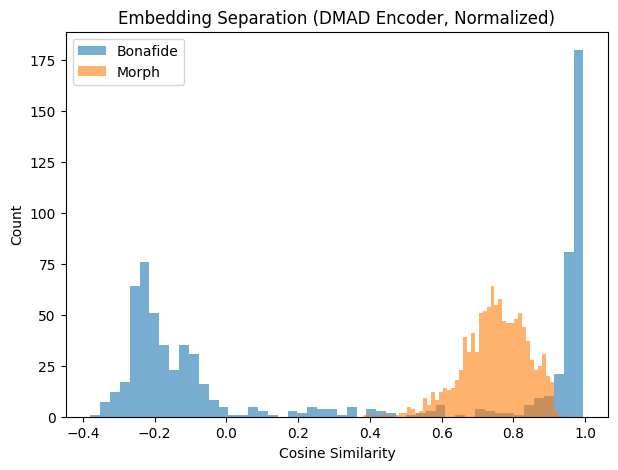

In [28]:
plot_embedding_distance_distribution(dmad_model, frll_test_loader,device)


In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(all_labels, all_scores, threshold):
    preds = (all_scores >= threshold).astype(int)  # morph = 1

    cm = confusion_matrix(all_labels, preds)

    plt.figure(figsize=(5,4))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Bona Fide", "Morph"],
        yticklabels=["Bona Fide", "Morph"]
    )

    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix (Cosine Threshold)")
    plt.tight_layout()
    plt.show()



==================== cuda:0 RESULTS ====================

📌 CLASSIFIER-BASED (LOGITS)
Accuracy:       98.98%
Precision:      0.9830
Recall:         1.0000
F1-Score:       0.9914
ROC-AUC:        0.9998

📌 COSINE-BASED (THRESHOLD)
Best Threshold: 0.9489
Accuracy:       84.00%
Precision:      0.7885
Recall:         0.9973
F1-Score:       0.8807
ROC-AUC:        0.7173
FAR:            0.0027
FRR:            0.3884
EER:            0.3104
Avg Bona Cosine:        0.7692
Avg Morph Cosine:       0.9837



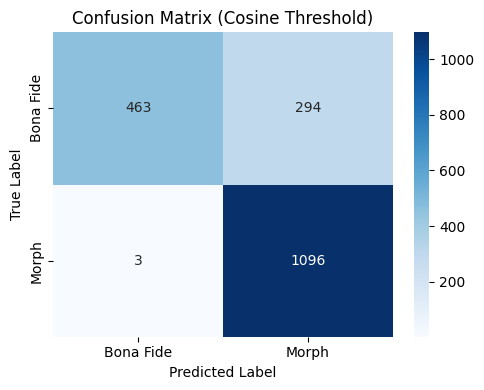

In [32]:
result= evaluate_dmad_both(dmad_model, frll_test_loader, device)

all_labels = result["_all_labels"]
all_scores = result["_all_cos"]
best_t     = result["cosine"]["threshold"]

plot_confusion_matrix(all_labels, all_scores, best_t)


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(all_labels, all_cos, title="ROC Curve (Cosine Similarity)"):
    fpr, tpr, thresholds = roc_curve(all_labels, all_cos)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
    plt.plot([0, 1], [0, 1], 'k--')   # diagonal line
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


In [ ]:
def plot_cosine_distribution(all_cos, all_labels, title="Cosine Similarity Distribution"):
    bona = all_cos[all_labels == 0]
    morph = all_cos[all_labels == 1]

    plt.figure(figsize=(7, 5))
    plt.hist(bona, bins=40, alpha=0.6, label="Bona-fide", color="blue")
    plt.hist(morph, bins=40, alpha=0.6, label="Morph", color="red")
    plt.axvline(bona.mean(), color="blue", linestyle="--")
    plt.axvline(morph.mean(), color="red", linestyle="--")
    plt.xlabel("Cosine Similarity")
    plt.ylabel("Frequency")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


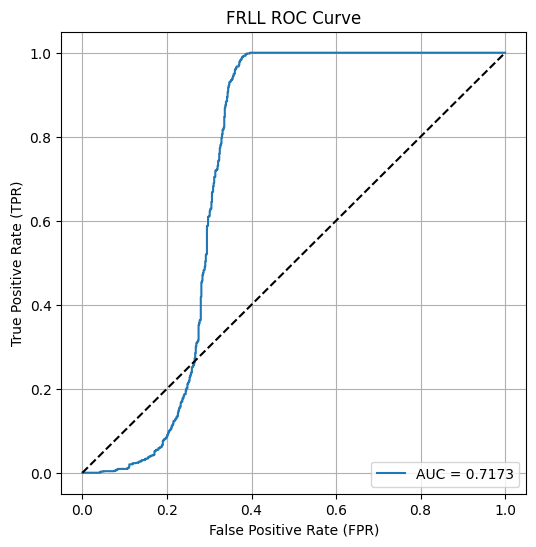

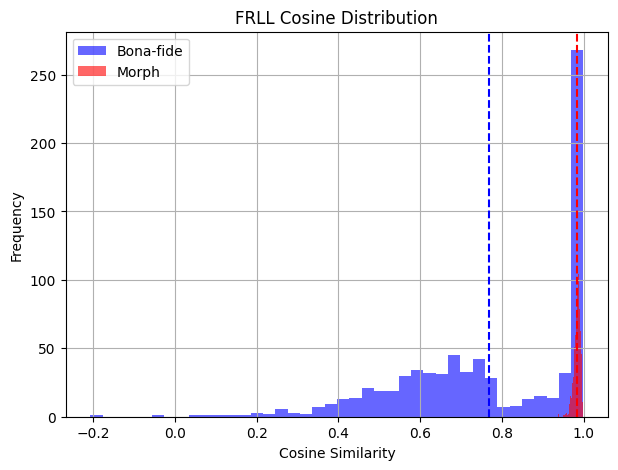

In [ ]:

all_cos = results["_all_cos"]
all_labels = results["_all_labels"]

plot_roc_curve(all_labels, all_cos, "FRLL ROC Curve")
plot_cosine_distribution(all_cos, all_labels, "FRLL Cosine Distribution")
